In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OrdinalEncoder  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, r2_score

In [3]:
df= pd.read_csv('twitter_training.csv', names=['Tweet_ID','Topic','Sentiment', 'Tweets'], encoding='ISO-8859-1')

# EDA (Exploratory Data Analysis)

In [3]:
df.sample(10)

,Tweet_ID,Topic,Sentiment,Tweets
39157,5521,Hearthstone,Positive,One of the greats.
3568,1817,CallOfDutyBlackopsColdWar,Positive,I made for a crazy Cod Black Ops Cold Nations ...
58760,3273,Facebook,Negative,At this time of year when I tell Facebook to b...
23000,4341,CS-GO,Negative,csgo pls stop ranking me up games are getting ...
25335,4748,Google,Irrelevant,This is absolutely exactly what this party is ...
69386,3886,Cyberpunk2077,Irrelevant,@ Freet4nita because she's wonderful and fun.
25314,4745,Google,Positive,Google Maps is interesting and nostalgic. . I ...
39647,1206,Battlefield,Negative,shit is a mess.. is. from.be/scf03UZjBgk.. @Ba...
49608,6116,FIFA,Negative,FIFA 21 PRO CLUBS is BROKEN!! youtu.be/_7tfj9S...
33805,6606,Fortnite,Neutral,"Epic built a real soundstage for ""Fortnite"" co..."


In [4]:
df.shape

(74682, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet_ID   74682 non-null  int64 
 1   Topic      74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Tweets     73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [6]:
df.isna().sum()

Tweet_ID       0
Topic          0
Sentiment      0
Tweets       686
dtype: int64

In [7]:
df['Topic'].value_counts()

Topic
TomClancysRainbowSix                 2400
MaddenNFL                            2400
Microsoft                            2400
LeagueOfLegends                      2394
CallOfDuty                           2394
Verizon                              2382
CallOfDutyBlackopsColdWar            2376
ApexLegends                          2376
Facebook                             2370
WorldOfCraft                         2364
Dota2                                2364
NBA2K                                2352
TomClancysGhostRecon                 2346
Battlefield                          2346
FIFA                                 2340
Xbox(Xseries)                        2334
Overwatch                            2334
johnson&johnson                      2328
Amazon                               2316
PlayStation5(PS5)                    2310
HomeDepot                            2310
Cyberpunk2077                        2304
CS-GO                                2304
GrandTheftAuto(GTA)         

In [8]:
df[df['Topic']== 'Nvidia'].sample(5)

,Tweet_ID,Topic,Sentiment,Tweets
73883,9057,Nvidia,Positive,Love the
72788,8869,Nvidia,Neutral,Lol that Linus tech tips video on Nvidia... ha...
72894,8887,Nvidia,Positive,@nvidia @NVIDIAGeForce I can haz 3080 FE now??...
74272,9127,Nvidia,Positive,RT @NVIDIACreators : Please Take it to the Par...
74379,9146,Nvidia,Neutral,Don't miss anything exciting


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet_ID   74682 non-null  int64 
 1   Topic      74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Tweets     73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [10]:
df['Sentiment'].value_counts()

Sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x7921c92d8eb0>,
 [Text(0.6414093669225578, 0.8936408809046303, 'Negative'),
  Text(-1.0260553442286633, 0.39649770564254155, 'Positive'),
  Text(-0.31734499213929374, -1.0532293937999033, 'Neutral'),
  Text(0.9398173765782871, -0.5716146417662045, 'Irrelavant')],
 [Text(0.3498596546850315, 0.4874404804934347, '30.2'),
  Text(-0.5596665513974526, 0.21627147580502265, '27.9'),
  Text(-0.17309726843961473, -0.5744887602544927, '24.5'),
  Text(0.5126276599517929, -0.31178980459974787, '17.4')])

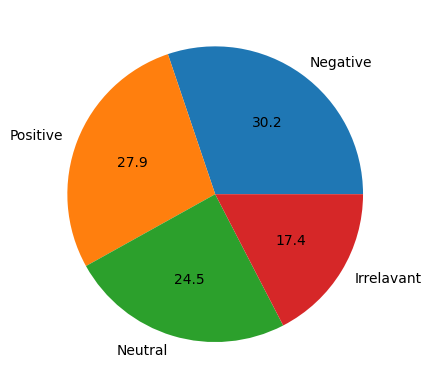

In [11]:
plt.pie(df['Sentiment'].value_counts(), labels=['Negative','Positive','Neutral','Irrelavant'],autopct='%0.1f')

In [12]:
# from ydata_profiling import ProfileReport
# eda=ProfileReport(df)
# eda.to_file(output_file='EDA_Report.html')

In [21]:
# removing the irrelevant entires as to make the dataset more balanced

df = df[df['Sentiment'] != 'Irrelevant']


In [22]:
df['Sentiment'].value_counts()

Sentiment
Negative    22542
Positive    20832
Neutral     18318
Name: count, dtype: int64

# Cleaning Data

In [24]:
df= df.drop(columns=['Tweet_ID'], axis=1)

In [25]:
df.shape

(61692, 3)

In [26]:
df= df.dropna(subset=['Tweets'])

In [27]:
df.shape

(61121, 3)

In [28]:
74682-73996

686

In [29]:
df.duplicated().value_counts()

False    58512
True      2609
Name: count, dtype: int64

In [30]:
df= df.drop_duplicates(keep='first')

In [31]:
df.shape

(58512, 3)

In [32]:
73996-70958 

3038

# Processing Tweets using the nltk module

In [33]:
import nltk
from nltk.stem import SnowballStemmer 
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import TreebankWordTokenizer


In [34]:
tw= df['Tweets'].sample().values[0]
tw

'So Warcraft 3 Reforged Activities will have issues if you have these original online Warcraft 3 applications installed. com But Warcraft 3 lan parties tonight are still fun.'

In [35]:
tb=TreebankWordTokenizer()
tb.tokenize(tw)

['So',
 'Warcraft',
 '3',
 'Reforged',
 'Activities',
 'will',
 'have',
 'issues',
 'if',
 'you',
 'have',
 'these',
 'original',
 'online',
 'Warcraft',
 '3',
 'applications',
 'installed.',
 'com',
 'But',
 'Warcraft',
 '3',
 'lan',
 'parties',
 'tonight',
 'are',
 'still',
 'fun',
 '.']

In [36]:
#creating columns to store the number of characters, words and sentences

df['characters']= df['Tweets'].apply(len)
df['words']= df['Tweets'].apply(lambda x: len(tb.tokenize(x)))
df['sentences']= df['Tweets'].apply(lambda x: len(sent_tokenize(x)))  

In [37]:
df

,Topic,Sentiment,Tweets,characters,words,sentences
0,Borderlands,Positive,im getting on borderlands and i will murder yo...,53,11,1
1,Borderlands,Positive,I am coming to the borders and I will kill you...,51,13,1
2,Borderlands,Positive,im getting on borderlands and i will kill you ...,50,11,1
3,Borderlands,Positive,im coming on borderlands and i will murder you...,51,11,1
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,57,13,1
...,...,...,...,...,...,...
74677,Nvidia,Positive,Just realized that the Windows partition of my...,128,26,1
74678,Nvidia,Positive,Just realized that my Mac window partition is ...,117,24,1
74679,Nvidia,Positive,Just realized the windows partition of my Mac ...,127,25,1
74680,Nvidia,Positive,Just realized between the windows partition of...,161,32,1


In [38]:
df[['characters', 'words', 'sentences']].describe()

,characters,words,sentences
count,58512.000000,58512.000000,58512.000000
mean,111.341263,22.273824,1.948113
std,79.556048,16.521026,1.620613
min,1.000000,0.000000,0.000000
25%,49.000000,10.000000,1.000000
50%,94.000000,18.000000,1.000000
75%,156.000000,31.000000,2.000000
max,957.000000,198.000000,33.000000


In [39]:
df['sentences'].unique()

array([ 1,  8,  4,  2,  6,  5,  3, 10,  7, 12,  9, 11, 14,  0, 15, 16, 13,
       18, 21, 20, 17, 25, 22, 19, 31, 33, 23, 24, 28])

In [40]:
print(df[df['sentences'] == 33]['Tweets'].values[0])

Today is  . . . No Amazon. . . No Walmart. . . No DoorDash. . . No Instacart. . . No Whole Foods. . . No Target. . . No GrubHub. . . No McDonalds. . . No Home Depot. . . No Bojangles. . For today, stand in solidarity with frontline workers and do your shopping another day.  


In [41]:
df['Sentiment'].value_counts().index

Index(['Negative', 'Positive', 'Neutral'], dtype='object', name='Sentiment')

In [42]:
for i in (df['Sentiment'].value_counts().index):    
    print('Table for',i)
    print(df[df['Sentiment'] == i][['characters','words','sentences']].describe())
    print()

Table for Negative
         characters         words     sentences
count  21565.000000  21565.000000  21565.000000
mean     114.280223     23.022583      1.835845
std       81.909385     16.699111      1.372155
min        1.000000      0.000000      0.000000
25%       48.000000     10.000000      1.000000
50%       95.000000     19.000000      1.000000
75%      164.000000     33.000000      2.000000
max      727.000000    198.000000     22.000000

Table for Positive
         characters         words     sentences
count  19549.000000  19549.000000  19549.000000
mean      99.160980     20.227275      1.917796
std       77.498124     16.251101      1.601854
min        1.000000      0.000000      0.000000
25%       40.000000      8.000000      1.000000
50%       78.000000     16.000000      1.000000
75%      138.000000     28.000000      2.000000
max      692.000000    198.000000     33.000000

Table for Neutral
         characters         words     sentences
count  17398.000000  17398.000

# EDA(again)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


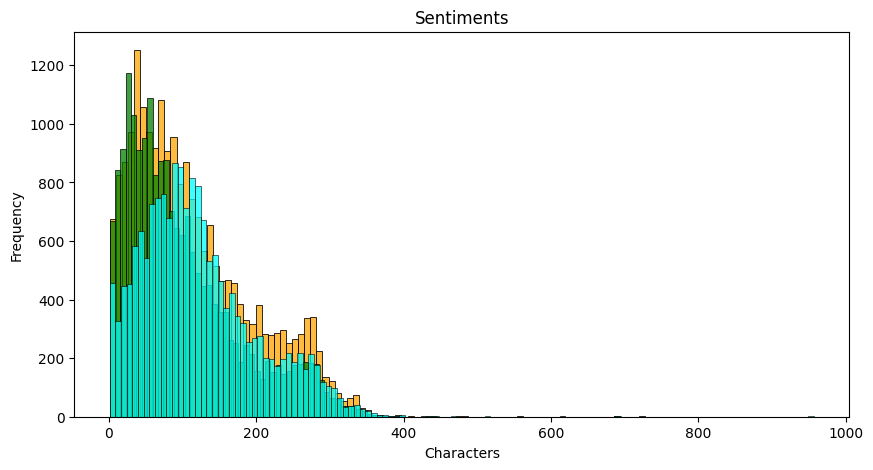

In [44]:
color_map = {
    'Positive': 'green',
    'Negative': 'orange',
    'Neutral': 'cyan',
}

plt.figure(figsize=(10,5))
plt.title('Sentiments')
plt.xlabel('Characters')
plt.ylabel('Frequency')
for SENTIMENT in (df['Sentiment'].value_counts().index): 
    COLOR=color_map.get(SENTIMENT, 'gray') # get(key, default value)
    sns.histplot(df[df['Sentiment']== SENTIMENT]['characters'], color=COLOR)
plt.show()

   # Data Processing

-> lower cases 
-> Tokenization
-> Removing special Charaecter
-> Removing stop words and punctuation
-> Stemming


In [45]:
#we fiurst renove the lower cases using tweet.lower() then we'll tokenize the tweet into words so as to remove any toekens which are english stopwords or are punctuations
import string
ss=SnowballStemmer(language='english') 

In [46]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [47]:
def transformed_tweet(tweet):
    
    temp_tweet=[]
    
    tweet=tweet.lower()
    tweet=tb.tokenize(tweet)
    for i in tweet:
        if i.isalnum() and i not in stopwords.words('english') and i not in string.punctuation:
            temp_tweet.append(ss.stem(i))
    
    return " ".join(temp_tweet) #uses the join function to join the elements in the list into a string
            

In [48]:
df['transformed_tweet']= df['Tweets'].apply(lambda x: transformed_tweet(x))

In [51]:
df1= df.copy()
df1

,Topic,Sentiment,Tweets,characters,words,sentences,transformed_tweet
0,Borderlands,Positive,im getting on borderlands and i will murder yo...,53,11,1,im get borderland murder
1,Borderlands,Positive,I am coming to the borders and I will kill you...,51,13,1,come border kill
2,Borderlands,Positive,im getting on borderlands and i will kill you ...,50,11,1,im get borderland kill
3,Borderlands,Positive,im coming on borderlands and i will murder you...,51,11,1,im come borderland murder
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,57,13,1,im get borderland 2 murder
...,...,...,...,...,...,...,...
74677,Nvidia,Positive,Just realized that the Windows partition of my...,128,26,1,realiz window partit mac like 6 year behind nv...
74678,Nvidia,Positive,Just realized that my Mac window partition is ...,117,24,1,realiz mac window partit 6 year behind nvidia ...
74679,Nvidia,Positive,Just realized the windows partition of my Mac ...,127,25,1,realiz window partit mac 6 year behind nvidia ...
74680,Nvidia,Positive,Just realized between the windows partition of...,161,32,1,realiz window partit mac like 6 year behind nv...


In [52]:
df[df['Sentiment']== 'Positive']['transformed_tweet'].shape

(19549,)

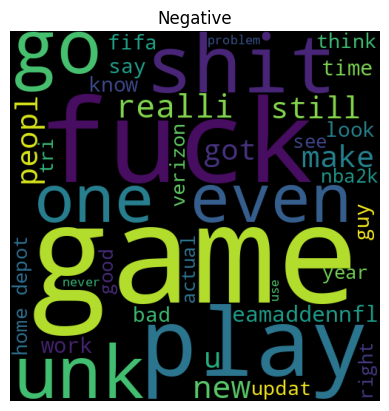

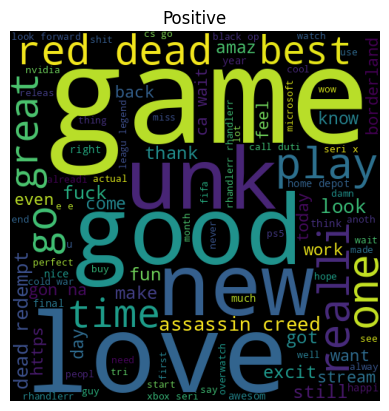

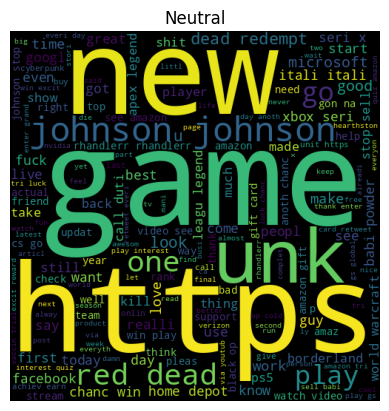

In [63]:
from wordcloud import WordCloud
wc=WordCloud(min_font_size=10, width=500, height=500)

for SENTIMENT in df['Sentiment'].value_counts().index:
    plt.figure()
    show_wc= wc.generate(df[df['Sentiment']== SENTIMENT]['transformed_tweet'].str.cat(sep= " ")) #str.cat(" ") joins all the words from the pandas series and makes it into a long corpus for the wordcloud to display
    plt.title(SENTIMENT)
    plt.imshow(show_wc)
    plt.axis("off")  #switches off the grapgh axis
    plt.show() # helps top show all 4 word clouds since jupyternotebook only shows the last executed code

# Enncoding Y

In [64]:
oe=OrdinalEncoder(categories=[['Negative','Positive','Neutral']])
df['Sentiment']=oe.fit_transform(df[['Sentiment']])

In [65]:
df['Sentiment'].value_counts()

Sentiment
0.0    21565
1.0    19549
2.0    17398
Name: count, dtype: int64

# Train Test Split

In [67]:
X=df['transformed_tweet']

In [68]:
y=df['Sentiment']

In [69]:
X= TfidfVectorizer(max_features=10000, smooth_idf=False,sublinear_tf=True).fit_transform(X).toarray()

In [70]:
X.shape

(58512, 10000)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

In [72]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46805,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [74]:
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [75]:
X_train.shape

(46809, 10000)

In [76]:
y_test.shape

(11703,)

# Checking for best Model 

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [78]:
clfs={
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier':DecisionTreeClassifier(max_depth=5),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5)  
}

In [79]:
    #mkaing the pipeline and encoding X
    accuracy_scores= []
    precision_scores= []


    for name, clf in clfs.items():
        print('working on model', clf)
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        accuracy_scores.append(accuracy_score(y_test, y_pred))
#         precision_scores.append(precision_score(y_test, y_pred))
        print(accuracy_score(y_test, y_pred))
        print()

working on model RandomForestClassifier()
0.9119029308724259

working on model DecisionTreeClassifier(max_depth=5)
0.41134751773049644

working on model KNeighborsClassifier()
0.9230111937110143



In [80]:
best_algo= pd.DataFrame({'Algorithm': clfs.keys(), 'Accuracy': accuracy_scores}).sort_values('Accuracy', ascending=False)
best_algo

,Algorithm,Accuracy
2,KNeighborsClassifier,0.923011
0,RandomForestClassifier,0.911903
1,DecisionTreeClassifier,0.411348


In [81]:
### now that we know that Random Forest gives the best reuslts, lets make a pipeline using RFC

# Pipeline

In [82]:
df.sample(10)

,Topic,Sentiment,Tweets,characters,words,sentences,transformed_tweet
67576,johnson&johnson,2.0,A massive lawsuit against Johnson & Johnson wi...,360,62,4,massiv lawsuit johnson johnson abl go ahead ju...
64277,MaddenNFL,0.0,@EAMaddenNFL<unk> why my player not catch it b...,174,41,2,eamaddennfl unk player catch kept catch nois 1...
73228,Nvidia,0.0,Nvidia. its Nvidia that constantly so reminds ...,72,14,2,nvidia constant remind today poor
4142,CallOfDutyBlackopsColdWar,1.0,The best game so far,20,5,1,best game far
73597,Nvidia,1.0,Holy shit NVIDIA kills them,27,5,1,holi shit nvidia kill
7152,Overwatch,2.0,SUPER LIVE with SUPER JUICE !!. . . . twitch...,58,12,5,super live super juic
61658,GrandTheftAuto(GTA),1.0,"The dream is to fill a lobby in GTA IV Online,...",311,65,3,dream fill lobbi gta iv onlin last night reach...
45832,Verizon,0.0,verizon is pissing even me off,30,6,1,verizon piss even
6794,Amazon,2.0,"How pathetic do you feel knowing your cage, a ...",235,48,2,pathet feel know cage penguin chain caricatur ...
38481,Hearthstone,1.0,A couple of you are new watching the last coup...,290,58,3,coupl new watch last coupl hearthston expans m...


In [83]:
X= df['transformed_tweet']

In [84]:
y= df['Sentiment']

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

In [86]:
pipe=Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=10000, smooth_idf=False, sublinear_tf=True)),
    ('RainForest',RandomForestClassifier(n_estimators=100, random_state=42))
])

In [87]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=10000, smooth_idf=False,
                                 sublinear_tf=True)),
                ('RainForest', RandomForestClassifier(random_state=42))])

In [88]:
y_pred= pipe.predict(X_test)

In [89]:
print(accuracy_score(y_test, y_pred))


0.9095958301290268


# Exporting Model

In [90]:
import pickle
pickle.dump(pipe, open('Model.pkl','wb'))

# Testing for predictions

In [101]:
def prediction(tweet):
    trans_tweet = transformed_tweet(tweet)
    tweet_list= [trans_tweet]
    prediction= pipe.predict(tweet_list)[0]
    return prediction

In [103]:
pred= (prediction('game sucks')).astype(int)




if pred ==0:
    print('Negative Comment')
elif pred ==1:
    print('Positive Comment')
elif pred ==2:
    print('Neutral Comment')

Negative Comment
